In [571]:
import pandas as pd
import glob 
import os 
import numpy as np
import re
import bs4 as bs
import urllib.request
import pandas as pd
pd.set_option('max_colwidth', 8000)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import svm


In [576]:
def aggr_files():
    df = pd.DataFrame()
    
    path = r'raw_data' # use your path

    all_files = glob.glob(os.path.join(path, "*.xls"))
    all_files1 = [f.replace(r".xls",".txt") for f in all_files]  ## replacing the file extension with .txt
    df_from_each_file = (pd.read_csv(f, delimiter = "\t") for f in all_files) ## reading the .txt files using csv reader
    df   = pd.concat(df_from_each_file, ignore_index=True)  ## concatenating all the individual files
#     for x in range(2,13):
#         temp_df = pd.read_excel('raw_data/nieuwe_leden_20210723 ('+str(x)+').xls')
#         df = pd.concat([df, temp_df])
    return df

def drop_private_cols(df):
    df = df.drop(['Geboortedatum','E-mailadres', 'Wat studeer je?','Telefoonnummer', 'Studentnummer'], axis = 1) # privacy sensitive
    df = df.drop(['Heb je je zwemdiploma A?','Anders, namelijk.1','Wat is het fanatiekst dat je hebt gesport?',
                 'Indien je niet in Amsterdam woont, ben je op zoek naar een kamer in Amsterdam?',
                 'Op Skøll eten veel mensen vegetarisch, pas je voorkeur hieronder aan als je toch wel vlees wilt eten',
                 'Namelijk', 'Wanneer verwacht je af te studeren?','Instituut','Ik wil naar Skøll voor',
                 'Wanneer ben je begonnen met je studie?','Heb je medische bijzonderheden waar wij rekening mee moeten houden?',
                 'Heb je allergieën waar wij rekening mee moeten houden?','Waar ken je Skøll van?',
                  'Heb je je naast sport op een ander gebied buitengewoon ingezet?',
                  'Zo ja, bij welke vereniging?','Hoeveel jaar heb je je langst beoefende sport beoefend?'
                 ], axis = 1)
    return df

def transform_df(df):
    df['Geslacht'].replace('Vrouw',0,inplace=True)
    df['Geslacht'].replace('Man',1,inplace=True)
    
    df['Heb je eerder geroeid?'].replace('Nee',0,inplace=True)
    df['Heb je eerder geroeid?'].replace('Ja',1,inplace=True)
    
    df['Gewicht (in kg)'] = df['Gewicht (in kg)'].str.extract('(\d+)')
    df['Lengte (in cm)'] = df['Lengte (in cm)'].str.extract('(\d+)')
    
    df['Zo ja, hoe lang?'].fillna('no', inplace=True)
    df['1+ jaar al geroeid'] = np.where(df['Zo ja, hoe lang?'].str.contains('jaar'), 1, 0)
    df.drop(['Zo ja, hoe lang?'], axis = 1, inplace = True)
    
    df['Hoe vaak kan roeien'] = df['Wanneer kun je roeien?'].str.count('ja').fillna(0)
    df.drop(['Wanneer kun je roeien?'], axis = 1, inplace = True)
    
    df['roeimotivatie'] = np.where(df['Waarom zou jij goed bij Skøll passen?'].str.contains('roei|sport|hard|wedstrijd'), 1, 0)
    df.drop(['Waarom zou jij goed bij Skøll passen?'], axis = 1, inplace = True)

    df['Welke sporten heb je beoefend?'] = df['Welke sporten heb je beoefend?'].str.split(',').str.len()
    df['Anders, namelijk'] = df['Anders, namelijk'].fillna('nothing')
    df['Anders, namelijk'] = df['Anders, namelijk'].str.split('(,|and)').str.len()
    df['hoeveel sporten vroeger beoefend'] = pd.to_numeric(df['Welke sporten heb je beoefend?']) + pd.to_numeric(df['Anders, namelijk']) - 1
    df.drop(['Anders, namelijk', 'Welke sporten heb je beoefend?'], axis = 1, inplace = True)
    
    mapdict1 = {'2 à 3 keer per week':2.5
               ,'Minder dan 2 keer per week':1
               ,'3 à 4 keer per week':3.5
               ,'Meer dan 4 keer per week':5
               ,'? keer per week': np.nan }
    df['# van plan te gaan roeien'] = df['Hoe vaak ben je van plan te gaan roeien per week?'].map(mapdict1)
    mapdict2 = {'2 à 3 keer per week':2.5,
        '3 à 4 keer per week':3.5,
        '4 à 5 keer per week':4.5,
        '? keer per week':0,
        'Meer dan 5 keer per week':6,
        'Minder dan 2 keer per week':1}
    df['# al geroeid'] = df['Zo ja, hoe vaak per week?'].map(mapdict2)
    df.drop(['Hoe vaak ben je van plan te gaan roeien per week?', 'Zo ja, hoe vaak per week?'], axis = 1, inplace = True)

    df['Wat is je beste sportprestatie?'] = df['Wat is je beste sportprestatie?'].fillna('nothing')
    df['sportroeiprestatie'] = np.where(df['Wat is je beste sportprestatie?'].str.contains('roei'), 1, 0)
    df.drop(['Wat is je beste sportprestatie?'], axis = 1, inplace = True)

    return df

df = aggr_files()
df = drop_private_cols(df)
df = transform_df(df)

In [577]:
print(df.shape)
df.head()

(2769, 12)


,Naam,Geslacht,Heb je eerder geroeid?,Gewicht (in kg),Lengte (in cm),1+ jaar al geroeid,Hoe vaak kan roeien,roeimotivatie,hoeveel sporten vroeger beoefend,# van plan te gaan roeien,# al geroeid,sportroeiprestatie
0,Iris Neijzen,0,1,62,180,1,18,1,3.0,5.0,1.0,0
1,Deben Oldert,1,0,65,176,0,15,1,5.0,3.5,0.0,0
2,Keri van Veen,0,0,76,175,0,15,1,1.0,2.5,0.0,0
3,Suzie van Kesteren,0,0,61,170,0,15,1,1.0,2.5,0.0,0
4,Renske van Druten,0,1,67,186,0,18,1,3.0,2.5,0.0,0


In [578]:

with open("raw_data/LedenMetBootjes.html", encoding='utf-8') as fp:
    soup = bs.BeautifulSoup(fp, 'html.parser')

table = soup.find(id='toolkit-table', attrs={'class':'wp-list-table widefat fixed posts'})

table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
bootjes = pd.DataFrame(l, columns=["Name", "SaxoId", 'WpId', 'Boten'])
bootjes.dropna(axis=0, inplace = True)
bootjes['Boten'] = bootjes['Boten'].str.split(',')
bootjes = bootjes[bootjes['Boten'].str.len() != 1]

In [579]:
# bootjes['TopC4'] = np.where(bootjes['Boten'].astype(str).str.contains('TopC'), 1, 0)
# bootjes['Talenten'] = np.where(bootjes['Boten'].astype(str).str.contains('Talenten '), 1, 0)
bootjes['Club'] = np.where(bootjes['Boten'].astype(str).str.contains('Club'), 1, 0)
bootjes['EerstejaarsWed'] = np.where(bootjes['Boten'].astype(str).str.contains('Eerstejaars'), 1, 0)
bootjes['MiddengroepWed'] = np.where(bootjes['Boten'].astype(str).str.contains('Middengroep'), 1, 0)
bootjes['Ouderejaars'] = np.where(bootjes['Boten'].astype(str).str.contains('Ouderejaars'), 1, 0)
bootjes['OudeVier'] = np.where(bootjes['Boten'].astype(str).str.contains('Oude Vier'), 1, 0)

bootjes['goldLabel'] = np.where(bootjes.iloc[:, 4:].any(axis='columns'), 1, 0)
# indb = bootjes[bootjes.iloc[:, 4:].any(axis='columns')].index.tolist() # select only the rowers who have done at least one of the above
label = bootjes.loc[:, ['Name', 'goldLabel']]
print(label.shape)
label.head()

(560, 2)


,Name,goldLabel
1,Dylan Houtman,0
2,Chrissy Rijkers,0
4,Michiel Moerman,1
5,Martijn Jong,1
7,Nina van Lierop,0


In [581]:
enddf = pd.merge(label, df, how='inner',left_on='Name', right_on='Naam')
enddf.drop(['Naam', 'Name'], axis = 1, inplace = True)
enddf['Gewicht (in kg)'] = enddf['Gewicht (in kg)'].astype(int)
enddf['Lengte (in cm)'] = enddf['Lengte (in cm)'].astype(int)
enddf.fillna(0, inplace = True)
print(enddf.columns)

scale_data = False
if scale_data:
    allcols = enddf.columns
    x = enddf.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    enddf = pd.DataFrame(x_scaled)
    enddf.columns = allcols
    
else:
    enddf.drop(['Lengte (in cm)','Gewicht (in kg)'],axis = 1,inplace = True) # gewicht and lengte appears to work negatively on the prediction score

dffemale = enddf[enddf['Geslacht'] == 0].drop(['Geslacht'], axis = 1)
dfmale = enddf[enddf['Geslacht'] == 1].drop(['Geslacht'], axis = 1)

Index(['goldLabel', 'Geslacht', 'Heb je eerder geroeid?', 'Gewicht (in kg)',
       'Lengte (in cm)', '1+ jaar al geroeid', 'Hoe vaak kan roeien',
       'roeimotivatie', 'hoeveel sporten vroeger beoefend',
       '# van plan te gaan roeien', '# al geroeid', 'sportroeiprestatie'],
      dtype='object')


In [538]:
print(enddf.shape)
enddf.head()

(750, 10)


,goldLabel,Geslacht,Heb je eerder geroeid?,1+ jaar al geroeid,Hoe vaak kan roeien,roeimotivatie,hoeveel sporten vroeger beoefend,# van plan te gaan roeien,# al geroeid,sportroeiprestatie
0,1,0,0,0,14,1,2.0,3.5,0.0,0
1,1,0,0,0,7,1,0.0,2.5,0.0,0
2,0,0,0,0,16,1,2.0,2.5,0.0,0
3,0,0,1,1,20,0,1.0,3.5,4.5,1
4,0,1,0,0,17,1,1.0,2.5,0.0,0


In [539]:
X, y = enddf.iloc[:,1:], enddf.iloc[:,0]
Xfem, yfem = dffemale.iloc[:,1:], dffemale.iloc[:,0]
Xmale, ymale = dfmale.iloc[:,1:], dfmale.iloc[:,0]


data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
ymale

4      0
8      1
11     0
12     0
15     0
      ..
737    1
738    1
739    1
746    1
747    1
Name: goldLabel, Length: 291, dtype: int32

In [540]:
def xgboost(X, y):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    xg_reg = xgb.XGBClassifier()
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    # classifiedpreds = [1 if x > 0.5000 else 0 for x in preds ] 
#     f1_score(y_test, preds)
    scores = cross_validate(xg_reg, X, y, cv=5,scoring='f1',return_train_score=True)
    return np.mean(scores['test_score'])
def neighbor(X, y):
    X.fillna(0, inplace = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    clfneigh = KNeighborsClassifier()
    clfneigh.fit(X_train, y_train)
    scores = cross_validate(clfneigh, X, y, cv=5,scoring='f1',return_train_score=True)
    return np.mean(scores['test_score'])

def tree(X, y):
    X.fillna(0, inplace = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    clftree = DecisionTreeClassifier()
    clftree.fit(X_train, y_train)
    scores = cross_validate(clftree, X, y, cv=5,scoring='f1',return_train_score=True)
    return np.mean(scores['test_score'])

def linear(X, y):
    X.fillna(0, inplace = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    clflinear = svm.SVC()
    clflinear.fit(X_train, y_train)
    scores = cross_validate(clflinear, X, y, cv=5,scoring='f1',return_train_score=True)
    return np.mean(scores['test_score'])

In [541]:
print('xgboost:\t',xgboost(X, y))
print('Neighbor:\t',neighbor(X, y))
print('Tree:\t\t',tree(X, y))
print('Tree:\t\t',linear(X, y))

xgboost:	 0.5712414530851908
Neighbor:	 0.4433873573808814
Tree:		 0.4518993632629996
Tree:		 0.3885024640352859


In [542]:
print('xgboost:\t',xgboost(Xfem, yfem), '\t', xgboost(Xmale, ymale))
print('Neighbor:\t',neighbor(Xfem, yfem), '\t', neighbor(Xmale, ymale))
print('Tree:\t\t',tree(Xfem, yfem), '\t', tree(Xmale, ymale))
print('Tree:\t\t',linear(Xfem, yfem), '\t', linear(Xmale, ymale))

xgboost:	 0.5201843131426791 	 0.7146405228758169
Neighbor:	 0.4228725038402458 	 0.5488089958821666
Tree:		 0.5369699245170944 	 0.6924189261031366
Tree:		 0.2171630015108276 	 0.5213535889397958


In [543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='binary:logistic')
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
# np.set_printoptions(suppress=True)
preds


array([0.00691922, 0.9376742 , 0.11467934, 0.9373665 , 0.9874835 ,
       0.06016918, 0.06396948, 0.91445833, 0.17718473, 0.0177622 ,
       0.91445833, 0.00675192, 0.99167144, 0.00072615, 0.53222454,
       0.02756135, 0.07468449, 0.9860496 , 0.02107809, 0.04111834,
       0.17718473, 0.39425558, 0.04057558, 0.92921394, 0.98069257,
       0.43794963, 0.49070588, 0.17718473, 0.9665364 , 0.84614277,
       0.8518595 , 0.01053967, 0.35653752, 0.10728332, 0.17718473,
       0.9904117 , 0.35653752, 0.9373665 , 0.01462397, 0.9579245 ,
       0.51298255, 0.20223689, 0.9874835 , 0.0003979 , 0.00131983,
       0.7213781 , 0.17095637, 0.01573051, 0.06396948, 0.01156218,
       0.98069257, 0.01156218, 0.12986003, 0.04057558, 0.43580788,
       0.93705666, 0.17718473, 0.03850719, 0.8518595 , 0.00370204,
       0.01156218, 0.03761862, 0.00786728, 0.17718473, 0.94533277,
       0.17718473, 0.04057558, 0.8599757 , 0.43794963, 0.00674823,
       0.98069257, 0.04726999, 0.49070588, 0.35653752, 0.78381

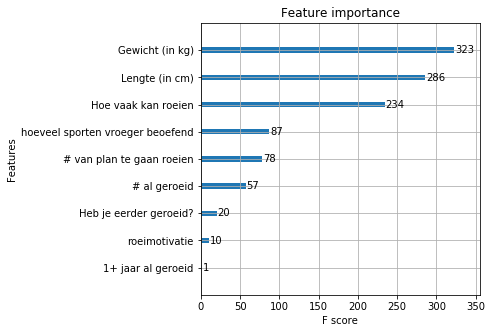

In [458]:
xg_reg = xgb.XGBClassifier()
xg_reg.fit(Xfem,yfem)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


Todo:
- 2 modellen maken voor Geslacht?
- genormaliseerd vs niet hebben ong zelfde resultaat, uitvinden welke de beste is

In [568]:
path = r'C:\Users\rvendrig\OneDrive - Deloitte (O365D)\Desktop\TechProjects\WedstrijdRoeiVoorspeller\test_set' # use your path
all_files = glob.glob(os.path.join(path, "*.xls"))
all_files1 = [f.replace(r".xls",".txt") for f in all_files]  ## replacing the file extension with .txt
df_from_each_file = (pd.read_csv(f, delimiter = "\t") for f in all_files) ## reading the .txt files using csv reader
inputdf = pd.concat(df_from_each_file, ignore_index=True)

inputdf = drop_private_cols(inputdf)
inputdf = transform_df(inputdf)
inputdf.fillna(0, inplace = True)
inputdf = inputdf.drop(['Lengte (in cm)','Gewicht (in kg)'],axis = 1) # gewicht and lengte appears to work negatively on the prediction score

X_male_test_w_name = inputdf[inputdf['Geslacht'] == 1].drop(['Geslacht'], axis=1)
X_female_test_w_name = inputdf[inputdf['Geslacht'] == 0].drop(['Geslacht'], axis=1)
X_male_test = X_male_test_w_name.drop(['Naam'], axis = 1)
X_female_test = X_female_test_w_name.drop(['Naam'], axis = 1)

xg_regmale = xgb.XGBRegressor(objective ='binary:logistic')
xg_regfemale = xgb.XGBRegressor(objective ='binary:logistic')
xg_regmale.fit(Xmale,ymale)
xg_regfemale.fit(Xfem,yfem)

predmale = xg_regmale.predict(X_male_test)
predfemale = xg_regfemale.predict(X_female_test)

X_male_test_w_name['prediction'] = np.around(predmale, 5)
X_female_test_w_name['prediction'] = np.around(predfemale, 5)
test_set = pd.concat([X_male_test_w_name, X_female_test_w_name])
test_set = test_set.loc[:, ['Naam','prediction']]
test_set.sort_values(by='prediction', ascending = False, inplace = True)
test_set

,Naam,prediction
9,Nina Burgering,0.99114
58,Mathilde Verster,0.98960
46,Simone de Groot,0.98404
49,Casper Kerckhoff,0.98190
50,Siem Leliveld,0.97766
20,Dieke Hania,0.91324
11,Jorre Lambregtse,0.88457
31,Jacob Groot,0.88457
33,Bruno Zorge,0.88457
5,Julia van de Vijver,0.86059
